In [4]:
import re
from collections import Counter
import powerlaw
import matplotlib.pyplot as plt
import pandas as pd

# ======= Step 1: Carica e tokenizza =======
text = """I

In the quaint, isolated town of Ravensbrook, where the ancient trees stood like gnarled fingers reaching for the heavens and the wind whispered through the branches with a mournful wail, a dark secret lay buried, hidden from the prying eyes of the world. A secret that had festered and grown in power for centuries, feeding off the fear and superstition of the townspeople. It was said that a curse had been placed upon Ravensbrook, a curse that could only be lifted by a soul of pure heart and courage, but with each passing generation, the hope of finding such an individual had dwindled.

The sun had long since vanished beneath the horizon, surrendering the sky to a vast, star-studded canopy that stretched out in all its infinite majesty. The moon, a thin, crescent sliver, cast a feeble, pallid glow over the landscape, casting elongated, monstrous shadows that danced and cavorted in the flickering light. It was on such a night that our story begins, with a young woman named Elara.

Elara was a raven-haired beauty with piercing, emerald-green eyes that seemed to hold a world of wisdom and sorrow within their depths. She was a skilled healer, knowledgeable in the ways of herbs and potions, and had earned the respect and admiration of the townspeople for her unwavering dedication to her craft. Yet despite her talents and the warmth she radiated, there was an inescapable aura of melancholy that clung to her like a shroud, a sadness that seemed to permeate her very essence. This melancholy was not born of self-pity or weakness, but rather a deep and abiding sorrow for the suffering she saw in the world, a suffering that she was powerless to alleviate.

As the darkness deepened, Elara found herself drawn to the ancient graveyard that lay on the outskirts of Ravensbrook, a place where the stones bore the names of generations long since passed and the wind howled with a mournful, keening lament. It was here, amidst the crumbling tombstones and tangled undergrowth, that she sought solace, her heart heavy with the weight of her burden.

As she wandered through the graveyard, her footsteps seemed to echo the rhythm of her heart, a slow and mournful beat that resonated with the very air around her. Suddenly, she stumbled upon a tomb that was unlike any she had seen before. It was a massive, imposing structure, hewn from the darkest, most foreboding stone, and seemed to draw the very light from its surroundings, casting a sinister pall over the area. The tomb was sealed by an intricate, iron-bound door that bore a sinister inscription:

"Here lies the soul of Malachor, the sorcerer who sought to conquer time and space, bound by the eternal chains of his own hubris, damned to slumber for all eternity, until the chosen one shall release him from his torment and bear the weight of his knowledge, his power, his curse."

The words seemed to seep into Elara's very being, filling her with a sense of dread that was as palpable as it was inexplicable. She felt an inexplicable connection to Malachor, a bond that seemed to defy the very laws of time and space. She knew, with a certainty that was as deep and profound as the ocean, that she was the chosen one, that she was destined to release Malachor from his torment and bear the weight of his curse.

With trembling hands, she reached for the door, her heart pounding in her chest like a frantic bird desperate to escape its cage. The door swung open with a groan that seemed to echo the very depths of her soul, revealing a narrow, winding staircase that descended into the bowels of the earth. The air was thick and heavy with the stench of decay, a miasma that seemed to cling to her very skin, filling her with a sense of revulsion and despair.

Undeterred, she descended the staircase, her heart hammering in her chest as if attempting to break free from her mortal coil. The darkness was absolute, a void that threatened to consume her very being, and yet she pressed on, driven by a force that was as mysterious as it was powerful.

At last, she reached the bottom of the staircase, where she found herself in a vast, subterranean chamber that seemed to stretch out for miles in all directions. The walls were lined with ancient, leather-bound tomes, their pages filled with the arcane knowledge of a forgotten age, and the air was thick with the scent of parchment and ink.

In the center of the chamber, there lay a stone sarcophagus, its surface etched with the same sinister inscription that adorned the door. The sarcophagus seemed to pulse with an unnatural energy, a dark and malevolent force that seemed to reach out to her with long, tendril-like fingers, seeking to ensnare her in its grip.

Summoning all her courage, she approached the sarcophagus, her heart pounding in her chest like a war drum. With trembling hands, she reached out to touch the cold, unyielding stone, her heart heavy with the weight of her decision. The moment her fingers made contact with the surface, a surge of energy pulsed through her, filling her with an indescribable power that seemed to both exhilarate and terrify her in equal measure.

As the energy subsided, the sarcophagus began to open, revealing the desiccated remains of a man who appeared to be at once ancient and timeless. His face was a mask of decay, a grotesque parody of the man he had once been, and yet his eyes seemed to burn with a malevolent, otherworldly power that seemed to defy the very laws of nature.

With a voice that seemed to echo from the very depths of the abyss, Malachor spoke:

"I have waited for centuries, my child, bound by the chains of my own hubris, and now, at last, you have come to release me from my torment. But know this, the power I possess is not to be trifled with, and the curse I bear is one that will haunt you for the remainder of your days. Are you prepared to accept this burden, to bear the weight of my knowledge, my power, my curse?"

Elara, her heart heavy with the weight of her decision, looked into Malachor's eyes and spoke, her voice filled with a conviction and a courage that belied her fear:

"I am prepared, Malachor, for I know that the power you possess is not meant to be contained, but rather to be used for the betterment of mankind. And though the curse you bear may be a heavy one, I know that I am strong enough to bear it, for I am the chosen one, and this is my destiny."

Malachor, his voice filled with a grudging admiration, spoke again:

"So be it, my child, for I know that you speak the truth, and I am bound by the very chains that have held me captive for so long to honor your decision. But know this, the path you have chosen is not an easy one, and the obstacles you will face are many. Yet I have faith in you, my child, for you are the chosen one, and you shall not falter in your mission."

And with those words, the chamber seemed to tremble and shake, as the ancient bonds that had held Malachor captive for so long were shattered, and the dark and malevolent energy that had permeated the air was released, filling the chamber with a power that seemed to both enlighten and consume all in its path.

As the energy began to subside, Elara found herself back in the graveyard, the memory of her encounter with Malachor etched into her very soul. She knew that the road ahead would be a difficult one, filled with trials and tribulations that would test her strength and her resolve. Yet she was not afraid, for she knew that she was the chosen one, and that she was destined to lift the curse that had haunted Ravensbrook for so long.

And so, with a newfound sense of purpose, she set off into the night, her heart filled with a courage and strength that seemed to defy the very laws of nature. The darkness that had once seemed so foreboding now seemed to fade before her, a mere shadow on the path to her destiny. And though the weight of Malachor's curse bore down upon her like a heavy yoke, she did not falter, for she knew that she was the chosen one, and that she would not fail in her mission.

As she journeyed through the dark and foreboding landscape, she found herself confronted by the very darkness that had once filled her with fear. Yet now, rather than cowering in the shadows, she embraced it, her newfound powers allowing her to see the beauty that lay hidden within the darkness, a beauty that was as mysterious as it was profound.

And so, through her trials and tribulations, Elara grew in strength and wisdom, her heart filled with a newfound understanding of the world around her. She had become the chosen one, the one who would lift the curse that had haunted Ravensbrook for so long, and in doing so, she had found a purpose and a meaning that had eluded her for so long.

But yet, the curse remained, a dark and malevolent force that seemed to cling to her very being, a constant reminder of the sacrifices she had made and the burdens she now bore. And though she fought valiantly to lift the curse, it remained, a stubborn and unyielding force that threatened to consume her, body and soul.

It was then that she realized that the true power of the curse was not to be found in its malevolent energy, but rather in the fear and superstition that it had instilled in the hearts of the people of Ravensbrook. For as long as they lived in fear, the curse would remain, a dark and looming specter that threatened to destroy them all.

And so, she set out to confront the people of Ravensbrook, her heart filled with a newfound determination and a courage that seemed to defy the very laws of nature. She knew that the path ahead would be a difficult one, filled with obstacles and challenges that would test her strength and her resolve, but she was undaunted, for she knew that she was the chosen one, and that she would not fail in her mission.

Finally, after what seemed like an eternity, she arrived in the town square, the heart of Ravensbrook, where the people had gathered to hear her words. And though they looked upon her with fear and suspicion, she spoke with a conviction and a courage that seemed to fill the very air with a power that was at once both enlightening and inspiring.

She spoke of the true nature of the curse, of the fear and superstition that had allowed it to fester and grow, and of the strength and courage that lay dormant within their hearts. And though they listened with skepticism and doubt, her words resonated with a truth that seemed to echo the very depths of their souls, a truth that could not be denied.

And so, the people of Ravensbrook, their hearts filled with a newfound courage and a determination to break free from the shackles of their fear, joined together to confront the darkness that had haunted them for so long. And though the battle was long and arduous, the power of their united hearts proved to be more than a match for the curse, and at last, the darkness was lifted, a faint glimmer of light appearing on the horizon, as if to herald the dawn of a new age.

As the people rejoiced, their hearts filled with a newfound hope and a joy that seemed to defy the very laws of nature, Elara stood among them, her heart heavy with a mixture of pride and sadness. For she knew that the power she had been given, the power that had allowed her to lift the curse, was not meant for her, but rather for the people of Ravensbrook, who now stood united in their resolve to face the challenges that lay ahead.

And so, with a quiet and unassuming grace, she slipped away from the celebrations, her heart filled with a sense of peace and fulfillment that seemed to fill the very air around her, a light that seemed to shine even in the darkest night. For she knew that her destiny was not to hoard the power that had been given to her, but rather to share it with those who needed it most, to light the way for others to follow.

And though the people of Ravensbrook would never fully understand the sacrifices she had made, or the burdens she had borne, they would always remember her, a beacon of hope and a symbol of the strength and courage that lay within their hearts. For she was the chosen one, the one who had lifted the curse and shown them the true power of unity and love.

As she walked away from Ravensbrook, the sun began to rise, its golden rays filling the sky with a light that seemed to both banish the shadows and illuminate the very essence of the world around her. And though the path ahead was uncertain, and the burdens she bore were heavy, she walked on, her heart filled with a newfound strength and a determination to face whatever challenges lay ahead.

For she was Elara, the chosen one, and her journey was far from over."""


In [18]:
def rank_frequs(text):
    # Tokenizzazione molto semplice: solo parole con lettere
    words = re.findall(r"\b[a-z]+\b", text)

    # Frequenza delle parole
    word_counts = Counter(words)
    frequencies = list(word_counts.values())

    # ======= Step 2: Crea un DataFrame ordinato per frequenza =======
    word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency'])
    word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)

    word_freq_df['rank'] = 1
    for i in range(1, len(word_freq_df)):
        if word_freq_df['frequency'][i] != word_freq_df['frequency'][i - 1]:
            word_freq_df['rank'][i] = word_freq_df['rank'][i - 1] + 1
        else: 
            word_freq_df['rank'][i] = word_freq_df['rank'][i -1]

    word_freq_df = word_freq_df[['rank', 'word', 'frequency']]
    word_freq_df['rel_freq'] = word_freq_df['frequency']/sum(word_freq_df['frequency'])

    return(word_freq_df)

In [20]:
df = rank_frequs(text)
df.head()

C:\Users\utente\AppData\Local\Temp\ipykernel_23832\1328291374.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  word_freq_df['rank'][i] = word_freq_df['rank'][i - 1] + 1
C:\Users\utente\AppData\Local\Temp\ipykernel_23832\1328291374.py:16:

,rank,word,frequency,rel_freq
0,1,the,169,0.077169
1,2,a,87,0.039726
2,3,and,84,0.038356
3,4,that,82,0.037443
4,5,to,78,0.035616


C:\Users\utente\AppData\Local\Temp\ipykernel_23832\1021625279.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  word_freq_df['rank'][i] = word_freq_df['rank'][i - 1] + 1
C:\Users\utente\AppData\Local\Temp\ipykernel_23832\1021625279.py:16:

Calculating best minimal value for power law fit
Alpha (scaling exponent): 2.093494296430886
xmin (starting point of power-law behavior): 3.0
Log-likelihood ratio (R): -0.0701616539929304
p-value: 0.7990066744078335


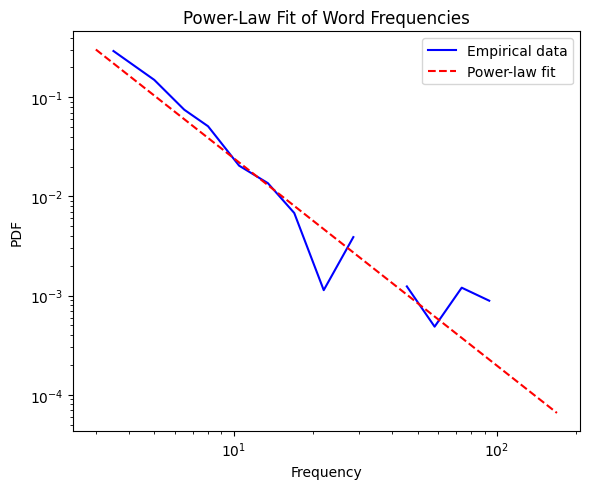

In [17]:
import powerlaw
import matplotlib.pyplot as plt

# Step 1: Get frequency data
freq_df = rank_frequs(text)  # assuming 'text' contains your corpus
frequencies = freq_df['frequency'].values

# Step 2: Fit power-law
fit = powerlaw.Fit(frequencies, discrete=True)
print("Alpha (scaling exponent):", fit.power_law.alpha)
print("xmin (starting point of power-law behavior):", fit.power_law.xmin)

# Step 3: Compare power-law to other distributions
R, p = fit.distribution_compare('power_law', 'lognormal')
print("Log-likelihood ratio (R):", R)
print("p-value:", p)

# Step 4: Plot
fig = plt.figure(figsize=(6, 5))
fit.plot_pdf(color='blue', label='Empirical data')
fit.power_law.plot_pdf(color='red', linestyle='--', label='Power-law fit')
plt.xlabel('Frequency')
plt.ylabel('PDF')
plt.legend()
plt.title('Power-Law Fit of Word Frequencies')
plt.tight_layout()
plt.show()
